# Ethnic Groups on Reddit 

##### Data Bootcamp, Fall 2022
##### Final Project
##### Alex Chae (yc4324)

### About my Project


My project is about how different ethnic groups identify themselves on the social media platform Reddit. Grabbing 250 comments each from subreddits for Black, White, Hispanic, Asian American and Pacific Islanders users, I will look at the factors that differentiate these groups the most through classification methods. Using Natural Language Processing, I also plan to conduct sentiment analysis of each subreddit and looking at the most frequently discussed topics and words used in each subreddit. I expect such analysis to lead to interesting results, shedding light into how different ethnic groups interact within the anonymous social media platform of Reddit. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, requests, warnings, os
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, silhouette_score, silhouette_samples
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from IPython.display import Image
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans, DBSCAN
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pmd

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from IPython.display import HTML

### Download Reddit Data, Clean Data

In [ ]:
url_black = 'https://api.pushshift.io/reddit/search/comment?subreddit=BlackPeopleTwitter&size=250'
url_white = 'https://api.pushshift.io/reddit/search/comment?subreddit=WhitePeopleTwitter&size=250'
url_aapi = 'https://api.pushshift.io/reddit/search/comment?subreddit=AsianAmerican&size=250'
url_hispanic = 'https://api.pushshift.io/reddit/search/comment?subreddit=Hispanic&size=250'

In [ ]:
r_black = requests.get(url_black)
r_white = requests.get(url_white)
r_aapi = requests.get(url_aapi)
r_hispanic = requests.get(url_hispanic)
data_black = r_black.json()
data_white = r_white.json()
data_aapi = r_aapi.json()
data_hispanic = r_hispanic.json()

In [ ]:
# Each list will contain reddit comments from the respective subreddit. 
ls_black = []
ls_white = []
ls_aapi = []
ls_hispanic = []

In [ ]:
for cmt_black in data_black['data']:
    ls_black.append(cmt_black['body'])
for cmt_white in data_white['data']:
    ls_white.append(cmt_white['body'])
for cmt_aapi in data_aapi['data']:
    ls_aapi.append(cmt_aapi['body'])
for cmt_hispanic in data_hispanic['data']:
    ls_hispanic.append(cmt_hispanic['body'])

In [ ]:
# ls_all contains all the comments

ls_all = []

for c in ls_black:
    ls_all.append((c, 'black'))
for cc in ls_white:
    ls_all.append((cc, 'white'))
for ccc in ls_aapi:
    ls_all.append((ccc, 'aapi'))
for ccccc in ls_hispanic:
    ls_all.append((ccccc, 'hispanic'))

# Remove comment from ls_all if the comment has been removed by Reddit (a.k.a. contains nothing)
for cmts in ls_all:
    if ('removed' in cmts[0]):
        ls_all.remove(cmts)

In [ ]:
ls_all[:5]

In [ ]:
# Making a dataframe of all comments

ls_ethnicity = []
ls_comments = []

for pairs in ls_all:
    ls_comments.append(pairs[0])
    ls_ethnicity.append(pairs[1])

df = pd.DataFrame({'Comment': ls_comments, 'Ethnicity': ls_ethnicity})

In [ ]:
# Save the dataframe as a csv file
df.to_csv('data.csv', index=False)

### Import the Dataset

In [198]:
# Read the csv file dataset
df = pd.read_csv('data.csv')
df.head()

,Comment,Ethnicity
0,Pavement Ape low-key rolls off the tongue.,black
1,They got Trevor Reed out earlier this year. He...,black
2,I used to run through a heavy Mexican gang are...,black
3,He gloated about that bullshit in our face for...,black
4,"Good luck. I'm not married yet, but recently l...",black


In [199]:
# See how many comments from each ethnicity are included in the dataset
pd.value_counts(df['Ethnicity'])

hispanic    248
white       241
aapi        229
black       191
Name: Ethnicity, dtype: int64

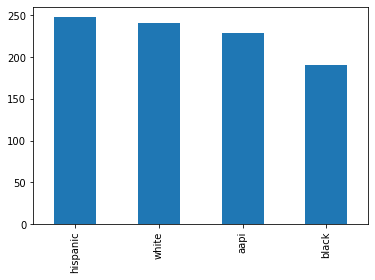

In [200]:
pd.value_counts(df['Ethnicity']).plot.bar();

The number of comments from each ethnicity. Although the numbers vary, there are around the same number of comments from each ethnicity, so I will continue to use this dataset for further analysis. 

### Each Ethnicity

I will first look at the data for each ethnicity and identify some characteristics. 

#### Black Subreddit

In [304]:
df_black = df.loc[df['Ethnicity'] == 'black']
ls_black = list(df_black['Comment'])

#### White Subreddit

In [305]:
df_white = df.loc[df['Ethnicity'] == 'white']
ls_white = list(df_white['Comment'])

#### Hispanic Subreddit

In [306]:
df_hisp = df.loc[df['Ethnicity'] == 'hispanic']
ls_hisp = list(df_hisp['Comment'])

#### AAPI Subreddit

In [307]:
df_aapi = df.loc[df['Ethnicity'] == 'aapi']
ls_aapi = list(df_aapi['Comment'])

After creating dataframes for each ethnicity, I plan to stem the comments before analyzing more. 

#### Stem Black Subreddit

In [308]:
stemmer = PorterStemmer()

In [309]:
# ls_black_splt splits each comment into separate tokens within a list for stemming. 
ls_black_splt= []

for cmt in ls_black:
    cmt_split = cmt.split()
    ls_black_splt.append(cmt_split)

ls_black_stem = []

for cmts in ls_black_splt:
    ls_cmt = []
    for words in cmts:
        ls_cmt.append(stemmer.stem(words))
    sep = " "
    cmt = sep.join(ls_cmt)
    ls_black_stem.append(cmt)
    
df_black_s = pd.DataFrame({'Comment': ls_black_stem, 'Ethnicity': 'Black'})

# We see here that each word in the comments are all reducted to their root form. 
ls_black_stem[:2]

['pavement ape low-key roll off the tongue.',
 'they got trevor reed out earlier thi year. he wa guilti of a crime. he wa pasty. he attack a polic officer. you peopl should do your research befor talk about thing you know noth about.']

In [310]:
cvect_black_s = CountVectorizer(stop_words='english')
black_cv_s = cvect_black_s.fit_transform(df_black_s['Comment'])

cvect_black_df_s = pd.DataFrame({'Token': list(cvect_black_s.vocabulary_.keys()), 'Count': list(cvect_black_s.vocabulary_.values())})
cvect_black_df_s = cvect_black_df_s.sort_values(by = 'Count', ascending= False)

top_words_black_s = []
for word in cvect_black_df_s['Token'][:20]:
    top_words_black_s.append(word.strip())

#### Stem White Subreddit

In [311]:
# ls_white_splt splits each comment into separate tokens within a list for stemming. 
ls_white_splt= []

for cmt in ls_white:
    cmt_split = cmt.split()
    ls_white_splt.append(cmt_split)

ls_white_stem = []

for cmts in ls_white_splt:
    ls_cmt = []
    for words in cmts:
        ls_cmt.append(stemmer.stem(words))
    sep = " "
    cmt = sep.join(ls_cmt)
    ls_white_stem.append(cmt)

df_white_s = pd.DataFrame({'Comment': ls_white_stem, 'Ethnicity': 'White'})

cvect_white_s = CountVectorizer(stop_words='english')
white_cv_s = cvect_white_s.fit_transform(df_white_s['Comment'])

cvect_white_df_s = pd.DataFrame({'Token': list(cvect_white_s.vocabulary_.keys()), 'Count': list(cvect_white_s.vocabulary_.values())})
cvect_white_df_s = cvect_white_df_s.sort_values(by = 'Count', ascending= False)

top_words_white_s = []
for word in cvect_white_df_s['Token'][:20]:
    top_words_white_s.append(word.strip())

#### Stem Hispanic Subreddit

In [312]:
# ls_h_splt splits each comment into separate tokens within a list for stemming. 
ls_h_splt= []

for cmt in ls_hisp:
    cmt_split = cmt.split()
    ls_h_splt.append(cmt_split)

ls_h_stem = []

for cmts in ls_h_splt:
    ls_cmt = []
    for words in cmts:
        ls_cmt.append(stemmer.stem(words))
    sep = " "
    cmt = sep.join(ls_cmt)
    ls_h_stem.append(cmt)

df_hisp_s = pd.DataFrame({'Comment': ls_h_stem, 'Ethnicity': 'Hispanic'})

cvect_h_s = CountVectorizer(stop_words='english')
h_cv_s = cvect_h_s.fit_transform(df_hisp_s['Comment'])

cvect_h_df_s = pd.DataFrame({'Token': list(cvect_h_s.vocabulary_.keys()), 'Count': list(cvect_h_s.vocabulary_.values())})
cvect_h_df_s = cvect_h_df_s.sort_values(by = 'Count', ascending= False)

top_words_h_s = []
for word in cvect_h_df_s['Token'][:20]:
    top_words_h_s.append(word.strip())

#### Stem AAPI Subreddit

In [313]:
# ls_aapi_splt splits each comment into separate tokens within a list for stemming. 
ls_aapi_splt= []

for cmt in ls_aapi:
    cmt_split = cmt.split()
    ls_aapi_splt.append(cmt_split)

ls_aapi_stem = []

for cmts in ls_aapi_splt:
    ls_cmt = []
    for words in cmts:
        ls_cmt.append(stemmer.stem(words))
    sep = " "
    cmt = sep.join(ls_cmt)
    ls_aapi_stem.append(cmt)

df_aapi_s = pd.DataFrame({'Comment': ls_aapi_stem, 'Ethnicity': 'AAPI'})
    
cvect_aapi_s = CountVectorizer(stop_words='english')
aapi_cv_s = cvect_aapi_s.fit_transform(df_aapi_s['Comment'])

cvect_aapi_df_s = pd.DataFrame({'Token': list(cvect_aapi_s.vocabulary_.keys()), 'Count': list(cvect_aapi_s.vocabulary_.values())})
cvect_aapi_df_s = cvect_aapi_df_s.sort_values(by = 'Count', ascending= False)

top_words_aapi_s = []
for word in cvect_aapi_df_s['Token'][:20]:
    top_words_aapi_s.append(word.strip())

In [314]:
top_words_s = pd.DataFrame({'Black' : top_words_black_s, 'White' : top_words_white_s, 'Hispanic' : top_words_h_s, 'AAPI': top_words_aapi_s})
top_words_s

,Black,White,Hispanic,AAPI
0,yup,zeusnostic,único,zej75z
1,yt,zeu,zootsuits,yt
2,youtube,zelenski,zombi,youtub
3,yooouuuu,zach,zero,young
4,yojc2pohbzshr5pdbi,younger,zendaya,yorker
5,yo,yes,zapata,york
6,yiclki5eqdmus,yep,yup,yikes
7,yeti,yell,youtub,yike
8,yeast,years,youtu,yes
9,years,year,youngest,yeoh


The table above shows the top 20 most frequently occuring stemmed words in each subreddit. We see that "youtube" is a common word that appears frequently in all of the subreddits. Also, there are some slang and derogatory terms that are appearing frequently. Through this table, we can notice some of the common themes that are talked about in each subreddit. In the Blakc subreddit, there are many words refering to one another, such as "yo" and "yall", and some words related to writing. Hence, this suggests that the Black subreddit contains a lot of conversations between the Reddit users and writing or literature is a frequent theme. 

Among the White users, the are words like "Zelenski" and "Zack" that most likely refer to an individual. Discussions on these individuals may be freqent in the White subreddit. 

Among the Hispanic users, there are some Spanish words used, such as "único" and "zapata." This shows that in this community, many users choose to talk in Spanish, rather than English, as it is a language related to their ethnicity. 

Among the AAPI users, "xenophobia" is a word that appears frequently, which suggests that discussions on racism is common. 

### Bigrams for Each Ethnicity 

Although the table above with the frequency of each token in the comments shows some interesting insights into each subreddit, some information are lacking. As the table above, made with each individual token might not provide the best outcome considering the context and structure of the tokens, I would like to do count the occurence of each bigram. 

#### Black Subreddit

In [244]:
df_black_2 = df.loc[df['Ethnicity'] == 'black']

cvect_black_2 = CountVectorizer(stop_words='english', ngram_range = (1, 2))
black_cv_2 = cvect_black_2.fit_transform(df_black_2['Comment'])

cvect_black_df_2 = pd.DataFrame({'Token': list(cvect_black_2.vocabulary_.keys()), 'Count': list(cvect_black_2.vocabulary_.values())}).sort_values(by = 'Count', ascending= False)

top_words_black_2 = []
for word in cvect_black_df_2['Token'][:20]:
    top_words_black_2.append(word.strip())

#### White Subreddit

In [245]:
df_white_2 = df.loc[df['Ethnicity'] == 'white']

cvect_white_2 = CountVectorizer(stop_words='english', ngram_range = (1, 2))
white_cv_2 = cvect_white_2.fit_transform(df_white_2['Comment'])

cvect_white_df_2 = pd.DataFrame({'Token': list(cvect_white_2.vocabulary_.keys()), 'Count': list(cvect_white_2.vocabulary_.values())}).sort_values(by = 'Count', ascending= False)

top_words_white_2 = []
for word in cvect_white_df_2['Token'][:20]:
    top_words_white_2.append(word.strip())

#### Hispanic Subreddit

In [247]:
df_hisp_2 = df.loc[df['Ethnicity'] == 'hispanic']

cvect_hisp_2 = CountVectorizer(stop_words='english', ngram_range = (1, 2))
hisp_cv_2 = cvect_hisp_2.fit_transform(df_hisp_2['Comment'])

cvect_hisp_df_2 = pd.DataFrame({'Token': list(cvect_hisp_2.vocabulary_.keys()), 'Count': list(cvect_hisp_2.vocabulary_.values())}).sort_values(by = 'Count', ascending= False)

top_words_hisp_2 = []
for word in cvect_hisp_df_2['Token'][:20]:
    top_words_hisp_2.append(word.strip())

#### AAPI Subreddit

In [248]:
df_aapi_2 = df.loc[df['Ethnicity'] == 'aapi']

cvect_aapi_2 = CountVectorizer(stop_words='english', ngram_range = (1, 2))
aapi_cv_2 = cvect_aapi_2.fit_transform(df_aapi_2['Comment'])

cvect_aapi_df_2 = pd.DataFrame({'Token': list(cvect_aapi_2.vocabulary_.keys()), 'Count': list(cvect_aapi_2.vocabulary_.values())}).sort_values(by = 'Count', ascending= False)

top_words_aapi_2 = []
for word in cvect_aapi_df_2['Token'][:20]:
    top_words_aapi_2.append(word.strip())

In [249]:
top_words_2 = pd.DataFrame({'Black' : top_words_black_2, 'White' : top_words_white_2, 'Hispanic' : top_words_hisp_2, 'AAPI': top_words_aapi_2})
top_words_2

,Black,White,Hispanic,AAPI
0,yup race,zeusnostic,único que,zej75z speed_being_racist_to_a_chinese_person
1,yup,zeus exists,único,zej75z
2,yt woman,zeus doesn,zootsuits remember,yt ppl
3,yt ladies,zeus,zootsuits,yt
4,yt,zelensky tv,zombie dog,youtubers interviewed
5,youtube com,zelensky,zombie,youtubers
6,youtube,zach new,zero importance,youtube videos
7,yooouuuu mom,zach,zero,youtube channel
8,yooouuuu,younger brother,zendaya just,youtube
9,yojc2pohbzshr5pdbi downsized,younger,zendaya,young working


The above table displays the 20 most popular monogram and bigrams from each subreddit. We see a similar trend with the previous table with some other interesting insights. 

In the black community, there are terms such as "yt woman" and "yt ladies" that may be derogatory terms that are often used in this subreddit. Again, there are many words related to "Youtube" as well. 

For the White subreddit, there are terms such as "zelensky" and "zach" and their bigrams that suggest that a lot of conversations are happening around these individuals, similar to the results from the previous table. There are many bigrams such as "yes good" and "yes course" that could be answers to a question. 

In the Hispanic subreddit, there are still a lot of Spanish words. There seems to be active discussions about zombies and the celebrity Zendaya. 

Lastly, in the AAPI subreddit, Youtube is a popular topic and also there are a lot of words related to young people, suggesting that the demographics of the AAPI subreddit may consist largely of younger people. 

### Sentiment Analysis

Now, I will conduct a sentiment analysis on each of the subreddits to see how the overall sentiment differes in each subreddit. 

#### Black Subreddit 

In [172]:
df_black_sent = df.loc[df['Ethnicity'] == 'black']

sentiment = SentimentIntensityAnalyzer()

pos = []
neu = []
neg = []

for cmt in list(df_black_sent['Comment']):
    sent_score = sentiment.polarity_scores(cmt)
    neg.append(sent_score['neg'])
    pos.append(sent_score['pos'])
    neu.append(sent_score['neu'])

def avg_ls(ls):
    return sum(ls) / len(ls)

ls_sent_b = []
ls_sent_b.append(avg_ls(neg))
ls_sent_b.append(avg_ls(neu))
ls_sent_b.append(avg_ls(pos))

#### White Subreddit

In [173]:
df_white_sent = df.loc[df['Ethnicity'] == 'white']

sentiment = SentimentIntensityAnalyzer()

pos = []
neu = []
neg = []

for cmt in list(df_white_sent['Comment']):
    sent_score = sentiment.polarity_scores(cmt)
    neg.append(sent_score['neg'])
    pos.append(sent_score['pos'])
    neu.append(sent_score['neu'])

ls_sent_w = []
ls_sent_w.append(avg_ls(neg))
ls_sent_w.append(avg_ls(neu))
ls_sent_w.append(avg_ls(pos))

#### Hispanic Subreddit

In [181]:
df_hisp_sent = df.loc[df['Ethnicity'] == 'hispanic']

sentiment = SentimentIntensityAnalyzer()

pos = []
neu = []
neg = []

for cmt in list(df_hisp_sent['Comment']):
    sent_score = sentiment.polarity_scores(cmt)
    neg.append(sent_score['neg'])
    pos.append(sent_score['pos'])
    neu.append(sent_score['neu'])

ls_sent_h = []
ls_sent_h.append(avg_ls(neg))
ls_sent_h.append(avg_ls(neu))
ls_sent_h.append(avg_ls(pos))

#### AAPI Subreddit

In [182]:
df_aapi_sent = df.loc[df['Ethnicity'] == 'aapi']

sentiment = SentimentIntensityAnalyzer()

pos = []
neu = []
neg = []

for cmt in list(df_aapi_sent['Comment']):
    sent_score = sentiment.polarity_scores(cmt)
    neg.append(sent_score['neg'])
    pos.append(sent_score['pos'])
    neu.append(sent_score['neu'])

ls_sent_a = []
ls_sent_a.append(avg_ls(neg))
ls_sent_a.append(avg_ls(neu))
ls_sent_a.append(avg_ls(pos))

In [183]:
df_sentiment = pd.DataFrame({'Black': ls_sent_b, 'White': ls_sent_w, 'Hispanic': ls_sent_h, 'AAPI': ls_sent_a})
df_sentiment.index = ['Negative', 'Neutral', 'Positive']
df_sentiment

,Black,White,Hispanic,AAPI
Negative,0.080806,0.10712,0.059520,0.086751
Neutral,0.805419,0.78549,0.841706,0.764498
Positive,0.098089,0.10739,0.094730,0.148751


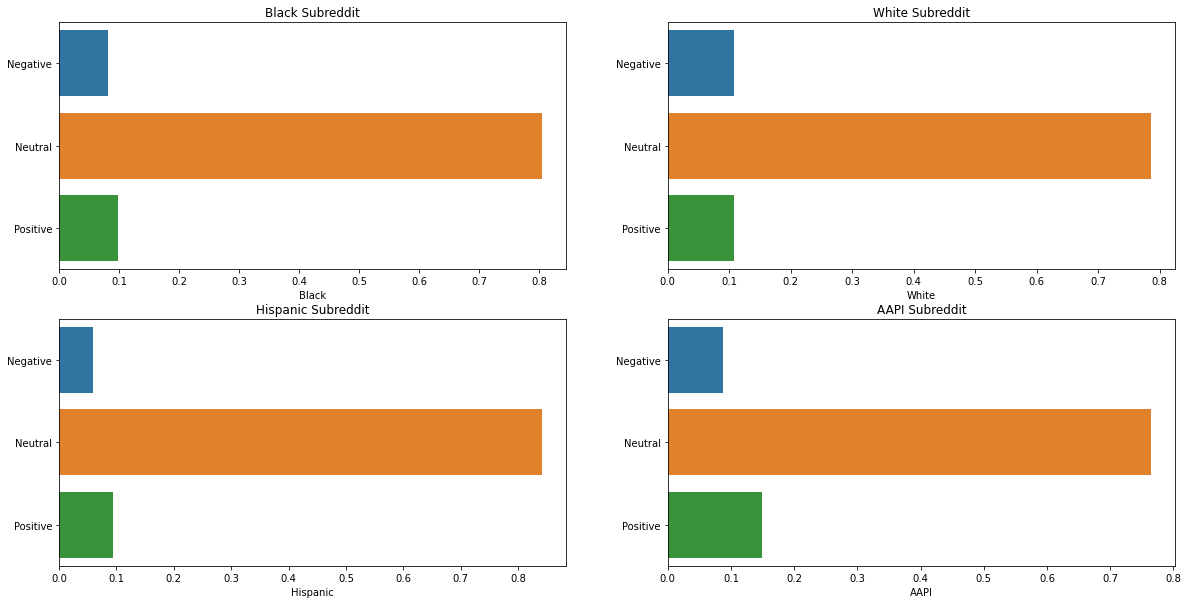

In [197]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10))
sns.barplot(data=df_sentiment, x=df_sentiment['Black'], y=df_sentiment.index, ax= ax[0,0])
ax[0, 0].set_title('Black Subreddit')
sns.barplot(data=df_sentiment, x=df_sentiment['White'], y=df_sentiment.index, ax= ax[0,1])
ax[0, 1].set_title('White Subreddit')
sns.barplot(data=df_sentiment, x=df_sentiment['Hispanic'], y=df_sentiment.index, ax= ax[1,0])
ax[1, 0].set_title('Hispanic Subreddit')
sns.barplot(data=df_sentiment, x=df_sentiment['AAPI'], y=df_sentiment.index, ax= ax[1, 1])
ax[1, 1].set_title('AAPI Subreddit');

The table and the graphs above shows the average sentiment score with the Valence Aware Dictionary and Sentiment Reasoner for each subreddit. In all of the four subreddits, neutral has the highest score (longest bar). There are some differences in the negative and positive scores as well. 

For the negative score, the White subreddit was the highest, followed by AAPI, Black and Hispanic subreddit. The hispanic subreddit has nearly half the negative sentiment score of that of White subreddit. The higher negative sentiment in the White subreddit is surprising, because the previous section showed that there are a lot of words such as "yes course" that show agreement. However, there might be negative sentiments coming from the conversations that continue after these words. In the Hispanic subreddit, there are a lot of people who identify as the same ethnicity and form a sense of tight community, as shown through the Spanish words in the previous sections, which contributes to a more positive environment. 

The positive score is highest among the AAPI subreddit, followed by the White, Hispanic and Black subreddit. The difference in positive scores between the subreddits is less than that of the negative scores. The AAPI subreddit might have the highest positive score, because the demographic likely consists of younger people and they are more aware of making a friendly online environment. As the previous sections show, there are some derogatory terms that are freqently occuring which may have lowered the positive score. 

### Binary Classifications 

Now I will conduct binary classifications. I will classify Black vs. White subreddits, because these two races are often mentioned together in the discussion of racism. I will also classify Hispanic vs. AAPI subreddits, because these two races are largely immigrant populations in the United States, so their differences and similarities might show interesting insights. 

#### Black vs. White Subreddit

In [341]:
df_black = df.loc[df['Ethnicity'] == 'black']
df_white = df.loc[df['Ethnicity'] == 'white']

In [342]:
# Each list contains the comments for each respective race. 
ls_black = list(df_black['Comment'])
ls_white = list(df_white['Comment'])

In [343]:
ls_bw = []
for comments in ls_black:
    ls_bw.append(comments)
for commentss in ls_white:
    ls_bw.append(commentss)
    
all_dic= {}

for x in ls_bw:
    if x in ls_black:
        eth = 'black'
    else: 
        eth = 'white'
    all_dic[x] = eth

# df_bw contains the comments from the Black and White subreddits. 
df_bw = pd.DataFrame({'Comment': list(all_dic.keys()), 'Ethnicity': list(all_dic.values())})

# Make binary variable (1 means black subreddit, 0 means white subreddit
df_bw['binary'] = np.where(df_bw['Ethnicity'] == 'black', 1, 0)

X = df_bw['Comment']
y = df_bw['binary']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=22)

In [344]:
# Baseline
y_train.value_counts(normalize= True)

0    0.582524
1    0.417476
Name: binary, dtype: float64

The baseline accuracy here is 0.583

In [345]:
pipe = Pipeline([('vectorizer', CountVectorizer(stop_words='english')), ('model', MultinomialNB())])

# GridSearch
params = {'vectorizer__min_df': [1, 2, 3, 4],
          'vectorizer__ngram_range': [(1, 1), (1, 2)], 
          'vectorizer__max_features': [2000, 3000, 4000, 5000]}

grid = GridSearchCV(pipe, param_grid = params, cv=5)
grid.fit(X_train, y_train)

print("Multinomial NB")
print("Best score: ", grid.best_score_)
print("Best parameters: ", grid.best_params_)
print("Score X_train: ", grid.score(X_train, y_train))
print("Score X_test: ", grid.score(X_test, y_test))

Multinomial NB
Best score:  0.6764145954521417
Best parameters:  {'vectorizer__max_features': 5000, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
Score X_train:  0.9741100323624595
Score X_test:  0.6826923076923077


We see here that the training data score is quite high and much higher than the baseline score with 0.974. However the difference with the testing data score is quite high as well, as the test data score is 0.683. So there seems to be a problem of overfitting. Nonetheless, the scores are better than the baseline accuracy. 

To see if a Logistic Regression model is better, we will conduct a Logistic Regression analysis as well. 

In [346]:
pipe2 = Pipeline([('vectorizer', CountVectorizer(stop_words = 'english')),
                 ('model', LogisticRegression())])

params2 = {'vectorizer__min_df': [1, 2, 3, 4],
          'vectorizer__ngram_range': [(1, 1), (1, 2)],
           'vectorizer__max_features': [2000, 3000, 4000, 5000]}

grid2 = GridSearchCV(pipe2, param_grid = params2, cv=5)
grid2.fit(X_train, y_train)

print("Logistic Regression")
print("Best score: ", grid2.best_score_)
print("Best parameters: ", grid2.best_params_)
print("Score X_train: ", grid2.score(X_train, y_train))
print("Score X_test: ", grid2.score(X_test, y_test))

Logistic Regression
Best score:  0.6894235854045478
Best parameters:  {'vectorizer__max_features': 2000, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1)}
Score X_train:  0.9902912621359223
Score X_test:  0.625


The results of the logistic regression model shows that the X_train data score is slightly higher than that of the Naive Bayes model. However, the X_test data score is even low, with 0.625. Therefore, the problem of overfitting is worse with Logistic Regression. Therefore, we will just use the Bayes model. 

Using the Naive Bayes model, I will draw a Confusion Matrix. 

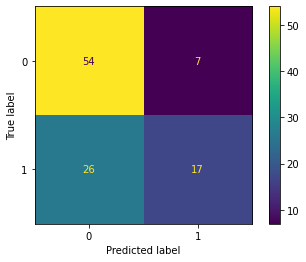

In [348]:
yhat = grid.predict(X_test)
confusion_matrix(y_test, yhat)
ConfusionMatrixDisplay.from_predictions(y_test, yhat);

This Confusion Matrix shows that there were a lot of errors in which the model predicted that a comment was from White subreddit, but it was in fact from Black subreddit (26 instances). Meanwhile, there were only 7 instances in which the model predicted that a comment was from Black subreddit and it was in fact from White subreddit. This shows that there might be a lot of similarities between the White and Black subreddit comments. 

In [321]:
import warnings
warnings.filterwarnings('ignore')

coefs = list(grid.best_estimator_.named_steps['model'].coef_.T)
tokens = list(grid.best_estimator_.named_steps['vectorizer'].get_feature_names_out())
impt_words = pd.DataFrame({'Coefficient': coefs, 'Words': tokens}).sort_values('Coefficient')
impt_words[:20]

,Coefficient,Words
2484,[-8.862058677395472],limb
2964,[-8.862058677395472],oil giving
2965,[-8.862058677395472],oil home
2968,[-8.862058677395472],ok
2969,[-8.862058677395472],ok abortion
2970,[-8.862058677395472],ok elons
2971,[-8.862058677395472],ok lol
2972,[-8.862058677395472],ok negotiate
2973,[-8.862058677395472],ok russia
2976,[-8.862058677395472],okay fuck


This dataframe shows the 20 words that are most influential in classifying a comment as from the White subreddit. We see some slang and derogatory terms here.

In [322]:
impt_words[-20:]

,Coefficient,Words
2054,[-7.252620764961372],humans
4843,[-7.070299208167418],work
4393,[-7.070299208167418],time
3145,[-7.070299208167418],person
4922,[-7.070299208167418],yeah
3470,[-7.070299208167418],really
1763,[-6.916148528340159],good
3878,[-6.916148528340159],shit
463,[-6.916148528340159],black
329,[-6.916148528340159],bad


Meanwhile this dataframe shows the 20 words that are most influential in classifying a comment as from the Black subreddit. We can see in this table that there are a lot of derogatory terms in the White subreddit as well, which makes classification difficult. Moreover, the Black subreddit includes a lot of words that does not add a significant new meaning, such as "really", "yeah", "like" and "just" so it might be harder to see if a comment is from the Black subreddit or not. It is interesting that unlike the White subreddit, words representing race such as "black" and "racist" are influential here. Hence, it might have been easier to identify a comment as black, through the inclusion of such words, than identifying a comment as White. 

#### AAPI vs. Hispanic Subreddit

In [349]:
df_aapi = df.loc[df['Ethnicity'] == 'aapi']
df_hisp = df.loc[df['Ethnicity'] == 'hispanic']

In [350]:
# Each list contains the comments for each respective race. 
ls_aapi = list(df_aapi['Comment'])
ls_hisp = list(df_hisp['Comment'])

In [351]:
ls_ah = []
for comments in ls_aapi:
    ls_ah.append(comments)
for commentss in ls_hisp:
    ls_ah.append(commentss)
    
all_ah= {}

for x in ls_ah:
    if x in ls_aapi:
        eth = 'aapi'
    else: 
        eth = 'hisp'
    all_ah[x] = eth

# df_ah contains the comments from the AAPI and Hispanic subreddits. 
df_ah = pd.DataFrame({'Comment': list(all_ah.keys()), 'Ethnicity': list(all_ah.values())})

# Make binary variable (1 means AAPI subreddit, 0 means Hispanic subreddit)
df_ah['binary'] = np.where(df_ah['Ethnicity'] == 'aapi', 1, 0)

X = df_ah['Comment']
y = df_ah['binary']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=22)

In [352]:
# Baseline
y_train.value_counts(normalize= True)

0    0.538235
1    0.461765
Name: binary, dtype: float64

Here, the baseline accuracy is 0.538

In [353]:
pipe = Pipeline([('vectorizer', CountVectorizer(stop_words='english')), ('model', MultinomialNB())])

# GridSearch
params = {'vectorizer__min_df': [1, 2, 3, 4],
          'vectorizer__ngram_range': [(1, 1), (1, 2)], 
          'vectorizer__max_features': [2000, 3000, 4000, 5000]}

grid = GridSearchCV(pipe, param_grid = params, cv=5)
grid.fit(X_train, y_train)

print("Best score: ", grid.best_score_)
print("Best parameters: ", grid.best_params_)
print("Score X_train: ", grid.score(X_train, y_train))
print("Score X_test: ", grid.score(X_test, y_test))

Best score:  0.8470588235294118
Best parameters:  {'vectorizer__max_features': 2000, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1)}
Score X_train:  0.961764705882353
Score X_test:  0.8070175438596491


Here, both the training data score and the testing data score is above the baseline accuracy, the model is helpful. The problem of overfitting seems to be less than the previous classification model between White and Black subreddits. 

Again, I will conduct a Logistic Regression model as well. 

In [354]:
pipe2 = Pipeline([('vectorizer', CountVectorizer(stop_words = 'english')),
                 ('model', LogisticRegression())])

params2 = {'vectorizer__min_df': [1, 2, 3, 4],
          'vectorizer__ngram_range': [(1, 1), (1, 2)],
           'vectorizer__max_features': [2000, 3000, 4000, 5000]}

grid2 = GridSearchCV(pipe2, param_grid = params2, cv=5)
grid2.fit(X_train, y_train)

print("Logistic Regression")
print("Best score: ", grid2.best_score_)
print("Best parameters: ", grid2.best_params_)
print("Score X_train: ", grid2.score(X_train, y_train))
print("Score X_test: ", grid2.score(X_test, y_test))

Logistic Regression
Best score:  0.8382352941176471
Best parameters:  {'vectorizer__max_features': 2000, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2)}
Score X_train:  0.9823529411764705
Score X_test:  0.7719298245614035


The performance of the Logistic Regression model compared to the Naive Bayes model is similar to the previous classification. The X_train score is slightly higher, but the X_test score is lower. Hence, there is a bigger problem of overfitting. We will use the Naive Bayes model as well. 

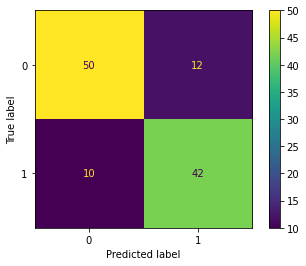

In [328]:
yhat = grid.predict(X_test)
confusion_matrix(y_test, yhat)
ConfusionMatrixDisplay.from_predictions(y_test, yhat);

The Confusion Matrix shows that there were around the same proportion of errors in which the model predicted a comment to be from the Hispanic subreddit, when it was actually from the AAPI subreddit and the other way around (12 instances out of 62 and 10 instances out of 52). 

In [329]:
coefs = list(grid.best_estimator_.named_steps['model'].coef_.T)
tokens = list(grid.best_estimator_.named_steps['vectorizer'].get_feature_names_out())
impt_words = pd.DataFrame({'Coefficient': coefs, 'Words': tokens}).sort_values('Coefficient')
impt_words[:20]

,Coefficient,Words
1999,[-8.429017500512511],zero
711,[-8.429017500512511],hablas
712,[-8.429017500512511],half
713,[-8.429017500512511],happen
1517,[-8.429017500512511],sooo
1514,[-8.429017500512511],son
1513,[-8.429017500512511],somos
1511,[-8.429017500512511],solicita
1510,[-8.429017500512511],sol
1507,[-8.429017500512511],socialize


This dataframe shows the 20 words that are most influential in classifying a comment as from the Hispanic subreddit. There are some words that are in Spanish, such as "hablas", "solicita", "somos", and "sol" which makes classification into Hispanic subreddit easier. Moreover, the mention of the word "hispanic" seems to be influential as well and classifies a comment into the Hispanic subreddit. 

In [330]:
impt_words[-20:]

,Coefficient,Words
709,[-5.9441108507245115],guy
1730,[-5.9441108507245115],time
1779,[-5.864068143050975],trying
1273,[-5.789960170897253],really
157,[-5.789960170897253],broadway
1927,[-5.65642877827273],white
1845,[-5.65642877827273],ve
881,[-5.65642877827273],lot
552,[-5.595804156456295],east
1389,[-5.595804156456295],say


Meanwhile, in the AAPI subreddit, there are also influential words that contain the word "asian," which makes the classification easier. Some words such as "really" and "just" do not contain a significant meaning, causing the errors shown in the Confusion Matrix. 

The presence of words that contain the same root, but are written in different forms, such as "asia" and "asian" demonstrate the need for stemming. Hence, here, I will stem the comments first and then conduct the same Naive Bayes model again. 

In [331]:
stemmer = PorterStemmer()

In [332]:
# ls_aapi_splt splits each comment into separate tokens within a list for stemming. 
ls_aapi_splt= []

for cmt in ls_aapi:
    cmt_split = cmt.split()
    ls_aapi_splt.append(cmt_split)

ls_aapi_stem = []

for cmts in ls_aapi_splt:
    ls_cmt = []
    for words in cmts:
        ls_cmt.append(stemmer.stem(words))
    sep = " "
    cmt = sep.join(ls_cmt)
    ls_aapi_stem.append(cmt)

# We see here that each word in the comments are all reducted to their root form. 
ls_aapi_stem[:2]

['flush nativ here. the broad gener of east vs west coast are also quit disturbing. ny is not philli or boston. sf is not seattl or la.',
 "same, idk what thi weirdo is on about. i live in queens, where vast stretch are veri unapologet and ruthlessli asian. to the point where alot of place don't even use english. which i argu is the peak american experience. it rather the demograph here aren't realli big on broadway musicals. and those of us who are, aren't go to wast money see a musical, especi in the age of the internet."]

In [333]:
# ls_hisp_splt splits each comment into separate tokens within a list for stemming. 
ls_hisp_splt= []

for cmt in ls_hisp:
    cmt_split = cmt.split()
    ls_hisp_splt.append(cmt_split)

ls_hisp_stem = []

for cmts in ls_hisp_splt:
    ls_cmt = []
    for words in cmts:
        ls_cmt.append(stemmer.stem(words))
    sep = " "
    cmt = sep.join(ls_cmt)
    ls_hisp_stem.append(cmt)

# We see here that each word in the comments are all reducted to their root form. 
ls_hisp_stem[:2]

['i might be realli late but spanish is my nativ language. when i wa younger i wa fluent in it and then as i went on to elementari school i wa forc to learn english which in turn made me forget most of my spanish. i had to take speech class as well and i even had a 504 which i think is due to the fact that i wasn’t use to english that well. now i’m fluent in english and i can understand everyth in spanish it’ just difficult for me to speak it.',
 'thi guy ha never heard of wet foot dri foot for 100 please!']

In [334]:
ls_ah_stem = []
for comments in ls_aapi_stem:
    ls_ah_stem.append(comments)
for commentss in ls_hisp_stem:
    ls_ah_stem.append(commentss)
    
all_ah_stem= {}

for x in ls_ah_stem:
    if x in ls_aapi_stem:
        eth = 'aapi'
    else: 
        eth = 'hisp'
    all_ah_stem[x] = eth

# df_ah contains the comments from the AAPI and Hispanic subreddits. 
df_ah_stem = pd.DataFrame({'Comment': list(all_ah_stem.keys()), 'Ethnicity': list(all_ah_stem.values())})

# Make binary variable (1 means AAPI subreddit, 0 means Hispanic subreddit)
df_ah_stem['binary'] = np.where(df_ah_stem['Ethnicity'] == 'aapi', 1, 0)

X = df_ah_stem['Comment']
y = df_ah_stem['binary']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=22)

In [335]:
pipe = Pipeline([('vectorizer', CountVectorizer(stop_words='english')), ('model', MultinomialNB())])

# GridSearch
params = {'vectorizer__min_df': [1, 2, 3, 4],
          'vectorizer__ngram_range': [(1, 1), (1, 2)], 
          'vectorizer__max_features': [2000, 3000, 4000, 5000]}

grid = GridSearchCV(pipe, param_grid = params, cv=5)
grid.fit(X_train, y_train)

print("Best score: ", grid.best_score_)
print("Best parameters: ", grid.best_params_)
print("Score X_train: ", grid.score(X_train, y_train))
print("Score X_test: ", grid.score(X_test, y_test))

Best score:  0.8558823529411764
Best parameters:  {'vectorizer__max_features': 2000, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1)}
Score X_train:  0.9588235294117647
Score X_test:  0.8157894736842105


A Gridsearch with a Naive Bayes model with the stemmed comments show that the scores are not that different from the model without stemming. The X_train data score is slightly lower, compared to 0.96 from the previous model. But the X_test score is slightly higher, meaning that there is slightly less overfitting in this model with stemming. The scores are all above the baseline accuracy. 

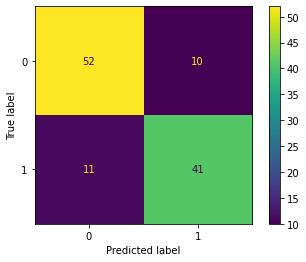

In [336]:
yhat = grid.predict(X_test)
confusion_matrix(y_test, yhat)
ConfusionMatrixDisplay.from_predictions(y_test, yhat);

The distribution of erros is similar here. It seems that stemming did not help improving the accuracy by a lot. 

In [337]:
coefs = list(grid.best_estimator_.named_steps['model'].coef_.T)
tokens = list(grid.best_estimator_.named_steps['vectorizer'].get_feature_names_out())
impt_words = pd.DataFrame({'Coefficient': coefs, 'Words': tokens}).sort_values('Coefficient')
impt_words[:20]

,Coefficient,Words
999,[-8.483222671845084],mexico
1119,[-8.483222671845084],paperwork
1118,[-8.483222671845084],panamaniand
1116,[-8.483222671845084],palabra
1115,[-8.483222671845084],pair
1111,[-8.483222671845084],padre
1110,[-8.483222671845084],pack
1121,[-8.483222671845084],para
1108,[-8.483222671845084],pa
1102,[-8.483222671845084],overarch


This table shows the list of the most influential stemmed words in classifying a comment as Hispanic subreddit. Now, the country of Mexico appears in the list, meaning that variations of the word "Mexico" has appeared frequently in the Hispanic comments. Again, we see some Spanish words that were influential. 

In [338]:
impt_words[-20:]

,Coefficient,Words
1737,[-5.7751724707428735],thing
1935,[-5.7106339496053025],white
965,[-5.7106339496053025],lot
658,[-5.650009327788868],east
809,[-5.650009327788868],ha
1790,[-5.487490398291094],tri
218,[-5.487490398291094],becaus
970,[-5.487490398291094],make
173,[-5.4387002341216615],asia
1320,[-5.4387002341216615],racism


For the AAPI subreddit, wee see that the word "asia" is much more influential now, mostly likely because a lot of variations of the wor dhas appeared on the AAPI comments. Again, some words such as "thing", "lot" and "just" that do not contain a significant meaning may make it difficult to classify, hence causing the errors. 

### Conclusion

This notebook gathered data of 250 comments on Reddit from 4 ethnic subreddits - Black People Twitter, White People Twitter, Asian American and Hispanic. The analysis of these data included looking at the most frequently occuring words and bigrams, overall sentiment analysis, and binary classification of races that are often related to one another. This dataset is not sufficient to draw out large conclusions of the four ethnicities, but it does show interesting insights into which conversations are happening frequently among each community and the characteristics of each community, which may lead to other research questions. 

To continue the findings of this analysis, larger datasets of social media communities of specific ethnicities could be analyzed. This analysis uses Reddit, as Reddit is a completely anonymous community with very low barriers of entry. Twitter has large ethnicity groups that are highly active as well and such analysis might provide interesting insights into the similarities and differences of different ethnicities, which show an important side of our society. 

Also, with the social media data, more higher level natural language processing analysis could be done. There are many previous literature discussing the presence of racism, sexism, and other forms of discrimination present on specific racial/ ethnic groups. Higher levels of natural language processing could show how such discrimination happens online, which will show how to prevent them. 